# Calculate Dislocation

In [1]:
import geopandas as gpd

vtds = gpd.read_file("../00_source_data/alarmshape 2021-10-07.shp")


In [2]:
vtds.columns


Index(['ID', 'STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'VTDI20',
       'NAME20', 'NAMELSAD20', 'LSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20',
       'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'OID_', 'GEOID20_1', 'RVPRE20',
       'DVPRE20', 'TPTYPRE20', 'RVPRES16', 'DVPRES16', 'TPTYPR16', 'RVUSS16',
       'DVUSS16', 'TPTYUSS16', 'STATEFP', 'COUNTYFP', 'DISTRICT', 'G18USSRREN',
       'G18USSDBRO', 'G18GOVRDEW', 'G18GOVDCOR', 'G18GOVLIRV', 'G18GOVGGAD',
       'G18ATGRYOS', 'G18ATGDDET', 'G18AUDRFAB', 'G18AUDDSPA', 'G18AUDLCOO',
       'G18SOSRLAR', 'G18SOSDCLY', 'G18SOSLNAN', 'G18TRERSPR', 'G18TREDRIC',
       'RVUSS18', 'DVUSS18', 'TPTYUSS18', 'RVGOV18', 'DVGOV18', 'TPTYGOV18',
       'RVATG18', 'DVATG18', 'TPTYATG18', 'RVAUD18', 'DVAUD18', 'TPTYAUD18',
       'RVSOS18', 'DVSOS18', 'TPTYSOS18', 'RVTRE18', 'DVTRE18', 'TPTYTRE18',
       'geometry'],
      dtype='object')

## Calc vote shares


In [3]:
elections = [
    "PRE20",
    "PRES16",
    "USS16",
    "USS18",
    "GOV18",
    "ATG18",
    "AUD18",
    "SOS18",
    "TRE18",
]

for p in ["D", "R"]:
    vtds[f"{p}_count"] = 0
    for e in elections:
        vtds[f"{p}_count"] += vtds[p + "V" + e]
    vtds[f"{p}_count"] = vtds[f"{p}_count"] / len(elections)


## Sanity Checks

<AxesSubplot:>

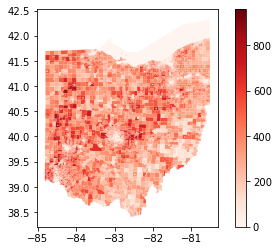

In [4]:
vtds.plot("R_count", cmap="Reds", legend=True)


<AxesSubplot:>

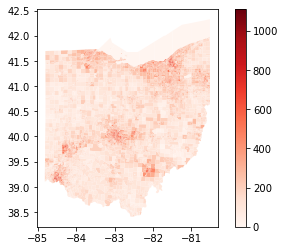

In [5]:
vtds.plot("D_count", cmap="Reds", legend=True)


In [6]:
vtds["D_count"].sum() / (vtds["D_count"].sum() + vtds["R_count"].sum())


0.46786351183282615

In [7]:
(vtds["D_count"].sum() + vtds["R_count"].sum())


4669177.466499511

## Create Representative Voters

In [8]:
import partisan_dislocation as pdn
sample_pct = 0.07
vtds = vtds.to_crs(epsg=26917)
voters = pdn.random_points_in_polygon(
    vtds, p=sample_pct, dem_vote_count="D_count", repub_vote_count="R_count"
)


In [9]:
len(voters)


326475

<AxesSubplot:>

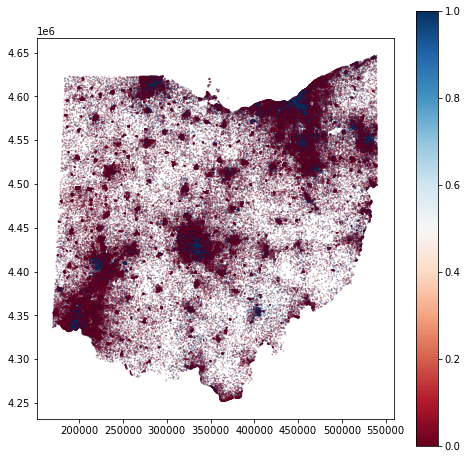

In [10]:
voters.plot("dem", cmap="RdBu", markersize=0.1, alpha=0.5, figsize=(8, 8), legend=True)


## Now KNN. 

In [15]:
for num_dists in [15, 99]:
    knn = pdn.calculate_voter_knn(
        voters, k=len(voters) / num_dists, target_column="dem"
    )
    knn = knn.to_crs(epsg=4326)
    knn.to_file(
        f"../20_intermediate_files/ohio_knn_{sample_pct:.2f}_sample_{num_dists}_dists.geojson"
    )
